# Disecting a one dimensional kernel function

**What this is not about:** Understand how a Support Vector Machines/Regression (SVM/SVR) works.

**Motivation:** Most tutorials and lectures on kernel functions focus on SVMs and how to solve the underlying optimization problem, but **kernel methods are much more than this**. I wanted to understand how this function class in general works. Kernel functions can be utilized whenever there is an inner product. As this function class is so versatile and neat to train, like neural networks they have been introduced into every area of modern machine learning, including:
- Classification
- Regression
- Clustering
- Dimensionality Reduction
- Time Series Analysis
- Outlier Detection
- Probabilistic Modelling

I have read about Mercer's theorem, the representer theorem, reproducing kernel Hilbert spaces and the reproducing property, symetric positive semi-definite matrices, Gram matrices, dual representations, KKT, Lagrange multipliers, etc.. But honestly, I am a practical person, so I wanted to practically play with this super general function class.

In [1]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
%matplotlib inline

Generate some sample- and prediction-data

In [2]:
X = np.linspace(0,6,50).reshape(-1,1)
y = np.sin(X).flatten()

Showing the learned function by prediction of X2

In [3]:
X2 = np.linspace(-2,7,1000).reshape(-1,1)

Train an RBF-SVR regression model to have something to play with.

In [4]:
svr = SVR(kernel='rbf', gamma=1.0, C=100)
svr.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

A look at the results

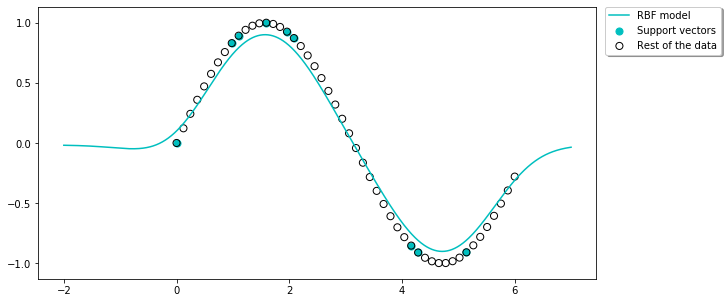

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X2, svr.predict(X2), color='c', label='RBF model')
ax.scatter(X[svr.support_], y[svr.support_], color='c', s=50, label='Support vectors')
ax.scatter(X, y, facecolor="none", edgecolor="k", s=50, label='Rest of the data')
ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1.02), ncol=1, fancybox=True, shadow=True)
plt.show()

**What happens when we choose our bandwith (~1/gamma) too small?**

In [6]:
svr = SVR(kernel='rbf', gamma=100.0, C=10)
svr.fit(X, y)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

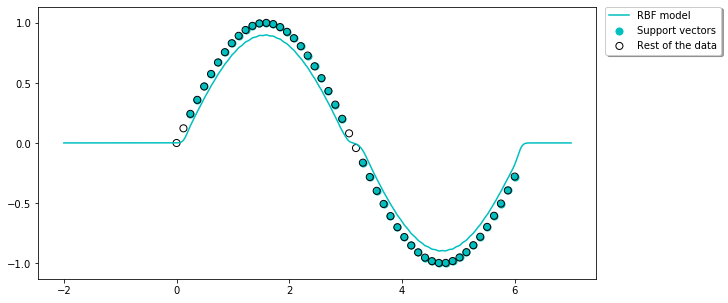

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X2, svr.predict(X2), color='c', label='RBF model')
ax.scatter(X[svr.support_], y[svr.support_], color='c', s=50, label='Support vectors')
ax.scatter(X, y, facecolor="none", edgecolor="k", s=50, label='Rest of the data')
ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1.02), ncol=1, fancybox=True, shadow=True)
plt.show()

The result is still good and the approximated function is still smooth, but we see that a lot more support vectors are used to make this happen.

**Now let's take only very few training samples and tune the bandwidth of the kernel to be even smaller** (i.e. choose a larger gamma value)

In [8]:
X = X[::5]
y = y[::5]

**Note, the implementation of the Gaussian Kernel in sklearn is like the following:** 

$K(x, y) = e^{(-\gamma ||x-y||^2)}$, which makes $\gamma \propto \frac{1}{\sigma}$, with $\sigma$ beeing the bandwith of the Gaussian bell curve.

See: [Documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)

Also note, that this is similar in shape, but not exactly the normalized Gaussian function which is oftrn used as probability density function:

$g(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

In [9]:
svr = SVR(kernel='rbf', gamma=15.0, C=10)
svr.fit(X, y)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=15.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

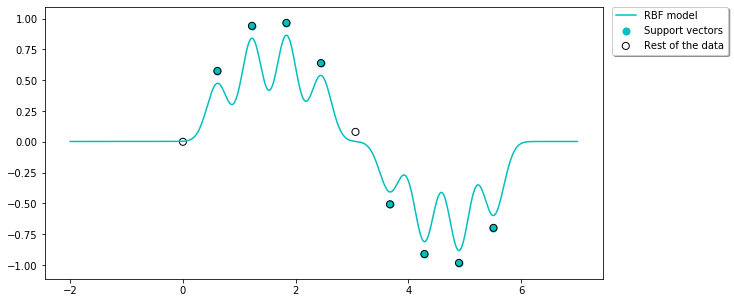

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X2, svr.predict(X2), color='c', label='RBF model')
ax.scatter(X[svr.support_], y[svr.support_], color='c', s=50, label='Support vectors')
ax.scatter(X, y, facecolor="none", edgecolor="k", s=50, label='Rest of the data')
ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1.02), ncol=1, fancybox=True, shadow=True)
plt.show()

We can see that smooth SVR-function which approximates our sine function so well starts to decompose and its building blocks (the Gaussian bells) start to show. 

**Ultimately the approximated function (the prediction) is the weighted sum of the Gaussian bells around the support vectors**

The indices of the support vectors

In [11]:
svr.support_

array([1, 2, 3, 4, 6, 7, 8, 9])

The support vectors themself (in our case only 1d vectors)

In [12]:
svr.support_vectors_

array([[0.6122449 ],
       [1.2244898 ],
       [1.83673469],
       [2.44897959],
       [3.67346939],
       [4.28571429],
       [4.89795918],
       [5.51020408]])

The alpha values (weights of the support vectors)

In [17]:
svr.dual_coef_

array([[ 0.46919097,  0.83331769,  0.85736884,  0.5329124 , -0.40673011,
        -0.80819239, -0.88025571, -0.59761169]])

The gaussian, as implemented for the kernel

In [39]:
def gaussian(x, mu, gamma):
    return np.e**(-gamma*abs(x-mu)**2)

Calculate the weighted Gaussian bell around each support vector 

In [40]:
gausseans = []
for i in range(len(svr.support_)):
    mu = svr.support_vectors_[i]
    alpha = svr.dual_coef_[0][i]
    gausseans.append(alpha*gaussian(X2, mu, gamma=15))
gausseans = np.array(gausseans)

**Plot**
- Each calculated weighted Gaussian bell around each support vector
- The sum of all weighted Gaussian bells
- The prediction of the SVR, which we utilized

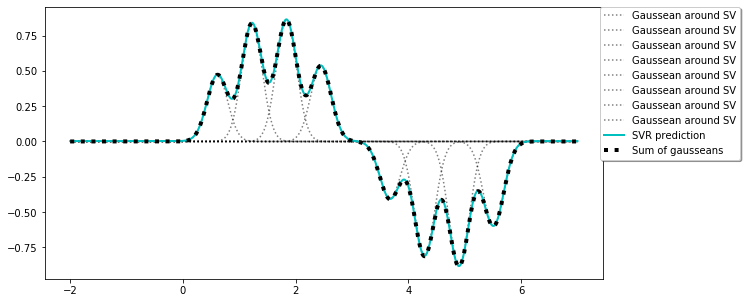

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))
for g in gausseans:
    ax.plot(X2, g, color='k', alpha=0.5, linestyle='dotted', label='Gaussean around SV')
ax.plot(X2, svr.predict(X2), color='c', linewidth=2, label='SVR prediction')
ax.plot(X2, gausseans.sum(axis=0), linewidth=4, color='k', linestyle='dotted', label='Sum of gausseans')
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 1.02), ncol=1, fancybox=True, shadow=True)
plt.show()

**Predicting new values, like the SVR does**

$f(x_{new}) = \sum_i^{\ell}\alpha_i K(x_i,x_{new})$ 

Since the alphas of non-support vectors are 0, we don't need to sum over all $\ell$ (training) data points.

In [69]:
alphas_and_SVs = list(zip(svr.dual_coef_[0], svr.support_vectors_))

In [99]:
def predict(x):
    prediction = 0
    for alpha, sv in alphas_and_SVs:
        prediction += alpha*gaussian(sv, x, gamma=15.0)
    return prediction

Plot the self made prediction vs. the one made by sklearns SVR library call

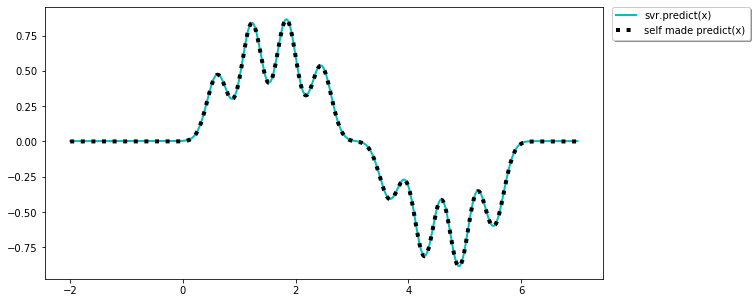

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X2, svr.predict(X2), color='c', linewidth=2, label='svr.predict(x)')
ax.plot(X2, predict(X2), color='k', linewidth=4, linestyle='dotted', label='self made predict(x)')
plt.legend(loc='upper center', bbox_to_anchor=(1.14, 1.02), ncol=1, fancybox=True, shadow=True)
plt.show()

Seems good to me =)

**My personal takeaways:**
- The approximated function (in data space, not feature space) is the weighted sum of the Gaussian bells around the support vector data points.


- But there is no need to construct/calculate any Gaussian. You can also use $f(x_{new}) = \sum_i^{\ell}\alpha_i K(x_i,x_{new})$ to calculate the kernel-functions value. :D This is what makes it so awesome!


- There is an **excellent read**/tutorial from two of the godfathers: [A tutorial on support vector regression](https://alex.smola.org/papers/2004/SmoSch04.pdf)


- **Why the name *kernel***? 
    - Mathematically a kernel of a linear mapping is the space of all vectors that are mapped to zero vector.
    - Kernel methods find a vector $w$ that is somehow interesting to your problem.
        - Sometimes you utilize the hyperplane which is orthogonal on $w$.
        - Sometimes the vector $w$ itself is of interst.
    - Back to the hyperplane. This is exactly the set of vectors, that have an inner product of zero with $w$.
    - Hyperplane = $\{x | w^\top x=0\}$ :D